## Jupyter Notebook to read in grib2 files from /weather directory and plot contoured maps
#### Originally coded by Patrick Beaty for AOS 311
#### pbeaty@wisc.edu

### __Important notes:__
In order to successfully run this notebook, the Python environment must have specific packages downloaded. The environment called 'pbeaty' has these downloaded and should have no errors running this notebook.

Packages needed:
- xarray, os, matplotlib, numpy, glob, cftime, cfgrib, eccodes, wrf, scipy, cartopy, siphon, metpy, pandas

In [39]:
import datetime
today = datetime.datetime.now()
print("Notebook last updated:", today.ctime())

#Import statements
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import cftime
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from scipy.ndimage.filters import gaussian_filter
from wrf import getvar, to_np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

Notebook last updated: Thu May  6 15:45:10 2021


In [41]:
#Ask user if they want the most current model run or a mode run from some other time
file_time = str(input('For most current model run, type 1. Otherwise, type 2:\nYour selection:'))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if file_time == '1':
    model_run = str(input('Which model forecast hour (F???) do you want? For example, hour 36 would be inputted as 036.\nYour selection:'))

For most current model run, type 1. Otherwise, type 2:
Your selection: 1


++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Which model forecast hour (F???) do you want? For example, hour 36 would be inputted as 036.
Your selection: 012


In [42]:
#Based on above kernel, define filetype with syntax of /weather/data/grib2 syntax
if file_time == '1':
    #Grab most current model run
    startTime=datetime.datetime.now()
    year = startTime.year
    if startTime.month <10:
        month = '0'+str(startTime.month)
    else:
        month = str(startTime.month)
    if startTime.day <10:
        day = '0'+str(startTime.day)
    else:
        day = str(startTime.day)
    if startTime.hour <10:
        hour = '0'+str(startTime.hour)
    else:
        hour = str(startTime.hour)
    mdate = str(year)+str(month)+str(day)
    def get_init_hr(hour):
        if int(hour) <6:
            init_hour = '00'
        elif int(hour) <12:
            init_hour = '06'
        elif int(hour) <17:
            init_hour = '12'
        elif int(hour) <22:
            init_hour = '18'
        else:
            init_hour = '00'
        return(init_hour)
    init_hour = get_init_hr(hour)
else:
    #User-defined file and model run
    year = int(input('Type desired year: '))
    month = str(input('Type desired month: '))
    day = str(input('Type desired day: '))
    init_hour = str(input('Type desired initialization hour (??). For example, hour 9 would be inputed as 09. '))
    model_run = str(input('Type desired model forecast hour (F???). For example, hour 36 would be inputted as 036. '))

filename = 'gblav0p25.'+str(year-2000)+str(month)+str(day)+str(init_hour)+'_F'+str(model_run)
print("We are going to run this file: ", filename)
dir_name = '/weather/data/grib2/'
file = dir_name + filename
print("The directory we are pulling the file from is: ", file)

We are going to run this file:  gblav0p25.21050612_F012
The directory we are pulling the file from is:  /weather/data/grib2/gblav0p25.21050612_F012


In [43]:
#Get the dataset from the above file
from cfgrib.xarray_store import open_dataset

ds = open_dataset(file,backend_kwargs={
                        'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'},
                        'errors': 'ignore'})

Can't create file '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Traceback (most recent call last):
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 343, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 264, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
OSError: [Errno 30] Read-only file system: '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Can't read index file '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Traceback (most recent call last):
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 353, in from_indexpath_or

In [44]:
#Ask user where they want to plot the dataset
#Current options are: 
#CONUS = 1, Northeast = 2, Southeast = 3, Gulf Coast = 4, Central Plains = 5,
#Northern Plains = 6, Southern Plains = 7, Great Lakes = 8, Southwest = 9, Northwest = 10
domain = str(input("Which region would you like to plot?\nCurrent options are:\nCONUS = 1, Northeast = 2, Southeast = 3, Gulf Coast = 4, Central Plains = 5,\nNorthern Plains = 6, Southern Plains = 7, Great Lakes = 8, Southwest = 9, Northwest = 10\nNorth America = 11, Europe = 12, Asia = 13, Africa = 14, Oceania = 15\nAustralia = 16, South America = 17, Central America = 18, Antarctica = 19\nSelection:"))

# Select a box that covers specified domain range
if domain == "1":
    wlon=230
    elon=295
    slat=25
    nlat=53
    print("Domain selection = CONUS")
elif domain == "2":
    wlon=275
    elon=295
    slat=38
    nlat=49
    print("Domain selection = Northeast")
elif domain == "3":
    wlon=265
    elon=285
    slat=25
    nlat=38
    print("Domain selection = Southeast")
elif domain == "4":
    wlon=260
    elon=283
    slat=25
    nlat=35
    print("Domain selection = Gulf Coast")
elif domain == "5":
    wlon=253
    elon=273
    slat=32
    nlat=45
    print("Domain selection = Central Plains")
elif domain == "6":
    wlon=253
    elon=273
    slat=38
    nlat=50
    print("Domain selection = Northern Plains")
elif domain == "7":
    wlon=253
    elon=273
    slat=25
    nlat=40
    print("Domain selection = Southern Plains")
elif domain == "8":
    wlon=265
    elon=285
    slat=40
    nlat=49
    print("Domain selection = Great Lakes")
elif domain == "9":
    wlon=235
    elon=255
    slat=30
    nlat=42
    print("Domain selection = Southwest")
elif domain == "10":
    wlon=232
    elon=252
    slat=38
    nlat=50
    print("Domain selection = Northwest")
elif domain == "11":
    wlon=181
    elon=320
    slat=10
    nlat=80
    print("Domain selection = North America")
elif domain == "12":
    wlon=0
    elon=60
    slat=30
    nlat=75
    print("Domain selection = Europe")
elif domain == "13":
    wlon=45
    elon=179
    slat=10
    nlat=75
    print("Domain selection = Asia")
elif domain == "14":
    wlon=0
    elon=70
    slat=-45
    nlat=40
    print("Domain selection = Africa")
elif domain == "15":
    wlon=95
    elon=160
    slat=-15
    nlat=30
    print("Domain selection = Oceania")
elif domain == "16":
    wlon=110
    elon=155
    slat=-45
    nlat=-10
    print("Domain selection = Australia")
elif domain == "17":
    wlon=270
    elon=330
    slat=-60
    nlat=15
    print("Domain selection = South America")
elif domain == "18":
    wlon=250
    elon=300
    slat=5
    nlat=30
    print("Domain selection = Central America")
elif domain == "19":
    wlon=0
    elon=359
    slat=-90
    nlat=-60
    print("Domain selection = Antarctica")
#If inputted wrong, plot CONUS
else:
    wlon=230
    elon=295
    slat=25
    nlat=53
    print("Domain selection = *** error, please retype ***")

Which region would you like to plot?
Current options are:
CONUS = 1, Northeast = 2, Southeast = 3, Gulf Coast = 4, Central Plains = 5,
Northern Plains = 6, Southern Plains = 7, Great Lakes = 8, Southwest = 9, Northwest = 10
North America = 11, Europe = 12, Asia = 13, Africa = 14, Oceania = 15
Australia = 16, South America = 17, Central America = 18, Antarctica = 19
Selection: 1


Domain selection = CONUS


In [45]:
#Get the dataset based on specified domain
data=ds.sel(latitude=slice(nlat,slat)).sel(longitude=slice(wlon,elon))
#Switch on to plot whole GFS domain
#data = ds
lat = data["latitude"]
lon = data["longitude"]

In [46]:
#Get the data from the dataset
var = (data["t"]-273.15) * (9/5) + 32 #convert to F
#Add cyclical point
var_wrap, lon_wrap = add_cyclic_point(var.values, coord=lon)
u = data["u"] #m/s
v = data["v"] #m/s
geopot = data["gh"] #gpm

In [49]:
#Ask user for desired isobaric level
vert_levs = ds["isobaricInhPa"].values
for i in range(len(vert_levs)):
    print("Inputing ", i, "= ", int(vert_levs[i]), "hPa")
lev = int(input("Which level would you like to plot?"))
print("Isobaric selection = ", int(vert_levs[lev]), "hPa")

Inputing  0 =  1000 hPa
Inputing  1 =  975 hPa
Inputing  2 =  950 hPa
Inputing  3 =  925 hPa
Inputing  4 =  900 hPa
Inputing  5 =  850 hPa
Inputing  6 =  800 hPa
Inputing  7 =  750 hPa
Inputing  8 =  700 hPa
Inputing  9 =  650 hPa
Inputing  10 =  600 hPa
Inputing  11 =  550 hPa
Inputing  12 =  500 hPa
Inputing  13 =  450 hPa
Inputing  14 =  400 hPa
Inputing  15 =  350 hPa
Inputing  16 =  300 hPa
Inputing  17 =  250 hPa
Inputing  18 =  200 hPa
Inputing  19 =  150 hPa
Inputing  20 =  100 hPa
Inputing  21 =  70 hPa
Inputing  22 =  50 hPa
Inputing  23 =  40 hPa
Inputing  24 =  30 hPa
Inputing  25 =  20 hPa
Inputing  26 =  15 hPa
Inputing  27 =  10 hPa
Inputing  28 =  7 hPa
Inputing  29 =  5 hPa
Inputing  30 =  3 hPa
Inputing  31 =  2 hPa
Inputing  32 =  1 hPa


Which level would you like to plot? 12


Isobaric selection =  500 hPa


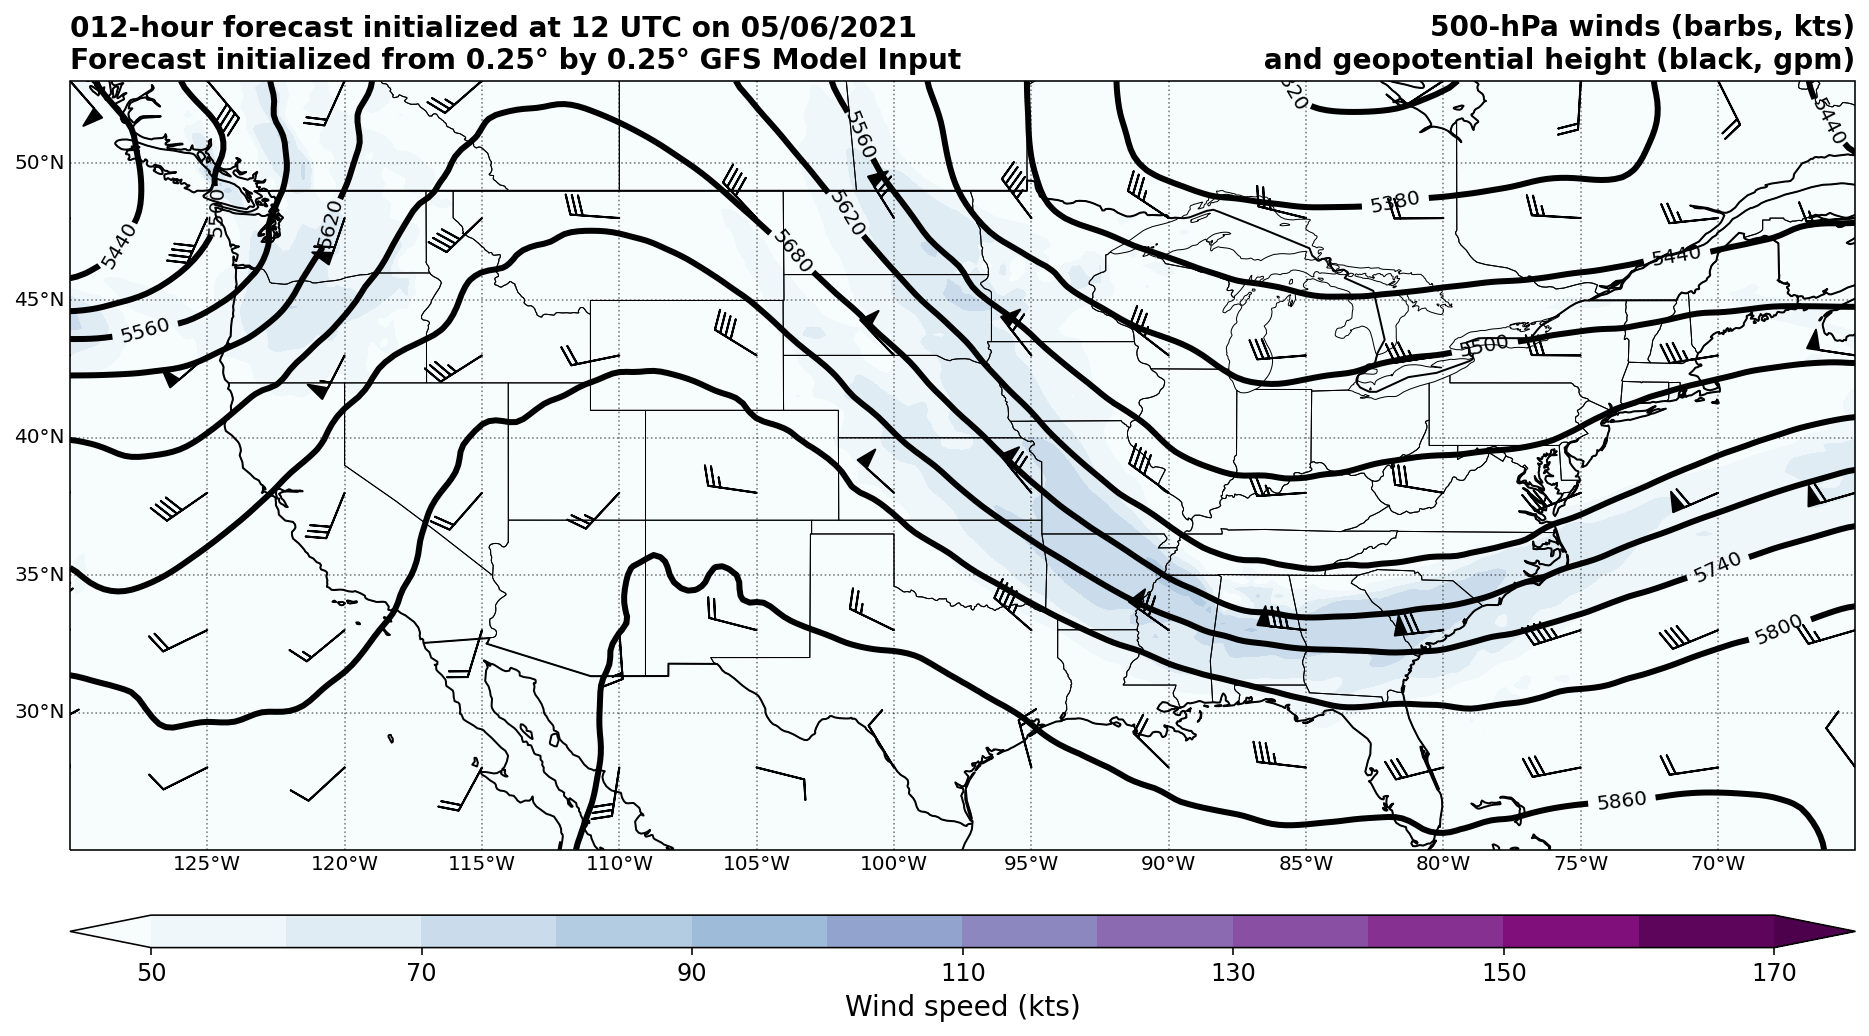

In [50]:
f=plt.figure(figsize=(16,12))
ax=plt.subplot(projection=ccrs.PlateCarree(central_longitude=0))

#Plot temp, height, and wind data
if lev==0:
    levels = np.arange(10,91,1)
    #Plot temp data
    plt.contourf(lon_wrap,lat,var_wrap[lev,:,:],levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°F)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    #Contour 32 degree line
    levels = [32]
    frz_contour = plt.contour(lon_wrap,lat,var_wrap[lev,:,:],levels=levels,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(frz_contour, fmt='%i', inline=True)
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round(var_wrap[lev,j,i]),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °F), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==1:
    levels = [0]
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='black')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    levels = np.arange(-15,36,1)
    plt.contourf(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°C)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round((var_wrap[lev,j,i]-32)*(5/9)),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °C), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==2:
    levels = [0]
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='black')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    levels = np.arange(-15,36,1)
    plt.contourf(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°C)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round((var_wrap[lev,j,i]-32)*(5/9)),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °C), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==3:
    levels = [0]
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='black')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    levels = np.arange(-20,31,1)
    plt.contourf(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°C)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round((var_wrap[lev,j,i]-32)*(5/9)),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °C), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==4:
    levels = [0]
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='black')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    levels = np.arange(-20,31,1)
    plt.contourf(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°C)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round((var_wrap[lev,j,i]-32)*(5/9)),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °C), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==5:
    levels = [0]
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='black')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    levels = np.arange(-25,26,1)
    plt.contourf(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), extend="both",cmap="turbo")
    #Define a colorbar for plotting data
    cb=plt.colorbar(orientation="horizontal", pad=.04)
    cb.set_label('Temp (°C)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    for j in range(5, len(lat)-5,10):
        for i in range(5, len(lon_wrap)-5,10):
            plt.text(lon_wrap[i],lat[j],round((var_wrap[lev,j,i]-32)*(5/9)),transform=ccrs.PlateCarree(central_longitude=0))
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(-360,3000,20)
    levels = levels[(levels < -1) | (levels > 1)]
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="white", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (fill, °C), winds (barbs, kts)\n and geopotential height (white, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==6:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==7:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==8:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==9:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==10:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==11:
    levels = np.arange(-100,45,5)
    #Plot temp data
    temp_contour = plt.contour(lon_wrap,lat,gaussian_filter(((var_wrap[lev,:,:]-32)*(5/9)),1.2),levels=levels,transform=ccrs.PlateCarree(central_longitude=0), colors='red')
    plt.clabel(temp_contour, fmt='%i', inline=True)
    #Plot wind data
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa temperature (red, °C), winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==12:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(1000,7000,60)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==13:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==14:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==15:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==16:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==17:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==18:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
elif lev==19:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')
else:
    #Plot wind data
    clevs_500_sped = np.arange(50, 180, 10)
    sped_500 = np.sqrt((u[lev,:]**2) + (v[lev,:]**2))*1.94384
    cf = plt.contourf(lon, lat, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=ccrs.PlateCarree(), extend="both")
    cb=plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
    cb.set_label('Wind speed (kts)',fontsize=14)
    cb.ax.tick_params(labelsize='large')
    if int(domain) > 1 and int(domain) < 11:
        spacing = 7
    else:
        spacing = 20
    Q = plt.barbs(lon_wrap[::spacing],lat[::spacing], \
        to_np(u[lev,::spacing,::spacing]*1.94384), to_np(v[lev,::spacing,::spacing]*1.94384),\
        length = 7, transform=ccrs.PlateCarree())
    #Plot geopotential height
    levels = np.arange(4000,19000,150)
    gpm_contour = plt.contour(lon,lat,gaussian_filter(geopot[lev,:,:],1.2),levels=levels, colors="black", linewidths=3,transform=ccrs.PlateCarree(central_longitude=0))
    plt.clabel(gpm_contour, fmt='%i', inline=True)
    plt.title(str(int(vert_levs[lev]))+"-hPa winds (barbs, kts)\n and geopotential height (black, gpm)", fontsize=14, loc="right", fontweight='bold')

#Add coastlines, lat and lon lines
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_lakes_shp")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  color='black', linestyle='dotted',alpha=0.5,zorder=11)
gl.xlocator = mticker.FixedLocator(np.arange(-180,185,5))
gl.ylocator = mticker.FixedLocator(np.arange(-90,95,5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlines = False
gl.ylines = False
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  color='black', linestyle='dotted',alpha=0.5,zorder=11)
gl1.xlocator = mticker.FixedLocator(np.arange(-180,185,5))
gl1.ylocator = mticker.FixedLocator(np.arange(-90,95,5))

#Title of plot
plt.title(str(model_run)+"-hour forecast initialized at "+str(init_hour)+' UTC on '+str(month)+'/'+str(day)+'/'+str(year)+'\nForecast initialized from 0.25° by 0.25° GFS Model Input',fontsize=14,loc='left', fontweight='bold')
plt.show()